<h2><center>ASSIGNMENT 3</center></h2>
<h2><center>DEEP ASHISH JARIWALA, JAYDEEP SINGH</center></h2>
<h2><center>GROUP - 31</center></h2>
<h2><center>Q: CM3</center></h2>

### IMPORTING LIBRARIES

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

### IMPORTING THE DATASET

In [25]:
from datasets import load_dataset
dataset = load_dataset('climate_fever')

Using custom data configuration default
Reusing dataset climate_fever (C:\Users\DEEP\.cache\huggingface\datasets\climate_fever\default\1.0.1\3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [26]:
dataset['test']

Dataset({
    features: ['claim_id', 'claim', 'claim_label', 'evidences'],
    num_rows: 1535
})

Observing the dataset, we see that the dataset is in the form of a dictionary and we will use claim and evidences as features to train our data, since these include sentences which can be used to train our model to generate word embeddings. 

### CONSTRUCTING CORPUS --- ALL SENTANCES IN THE DATASET

In [27]:
corpus = []
for item in dataset['test']:
    corpus.append(item['claim'])
    for evidence in item['evidences']:
        corpus.append(evidence['evidence'])

### TEXT PREPROCESSING USING NLTK

<p>As part of data preprocessing, following tasks are performed:<p>
<ul>
            <li>Tokenisation of the dataset</li>
            <li>Conversion to lowercase</li>
            <li>Removal of stopwords</li>
            <li>Removing punctuations, numbers and special characters</li>
            <li>Lemmatization</li>
            <li>Stemming</li>
</ul>

<p>Details of the preprocessing steps performed on the dataset:<p>
<ul>
            <li>As part of tokenization, we will split longer strings into texts of smaller tokens. Further processing will be done on the text only after it has been appropriately tokenized. Note that the input to word2vec will be a list of tokenized sentences, so that the context of each word when used in a sentence is preserved.</li>
            <li>We are converting all the data to lowercase do that same words are not treated differently because of difference in cases.This is neceassary so that words 'Earth' and 'earth' have same meaning but when not converted to lowercase, these would be treated as two different words in vector space.</li>
            <li>After that we need to remove stop words, these are the words which don't add any additional value to the document.Here we are using nltk library to download all the stop words in english language and then we filter our corpus so that it does not include these stop words.</li>
    <li>Numbers are generally converted to words when they contain a very useful information about the data for example in banking/financial data. Our data contains information about climate , where numbers are not adding any additional information to the data. So in this case, we are removing the numbers.</li>
<li>All the punctuation, numbers and special characters are removed from the corpus, as these are unnecesarry symbols and do not contain any additional information about the data. All these characters will only create unnecessary vectors in the vector space.</li>
            <li>Lemmatization reduces the words present in different forms to their base form which is also a meaningful dictionary word. It is necessary to reduce the text ambiguity. Here, we are using WordNet lemmatizer from the nltk library to lemmatize the text. </li>
            <li>Stemming is a text-normalisation technique that removes the prefix and affix from the words. For example words like "wait", "waiting", "waited", "waits" are reduced to "wait". We are using PorterStemmer in the nltk library to stem the tokens in the corpus. It is necessary as it reduces the converts different variations of the same word to a same form.</li>
</ul>

In [28]:
# TOKENIZING CORPUS TO PREPARE FOR Word2Vec EMBEDDING
from nltk.tokenize import word_tokenize
words_corpus = [word_tokenize(sentence) for sentence in corpus]

# TO REMOVE STOPWORDS
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
fil_list = []
for sentence_list in words_corpus:
    lower_case_sentence = [word.lower() for word in sentence_list]
    fil_list.append(list(filter(lambda x: x not in stop_words,lower_case_sentence)))

# LOWER CASE THE TEXT, REMOVING SPECIAL CHARACTERS AND INTEGERS
import re
final_corpus = []
for sentence_list in fil_list:
    final_corpus.append(list(filter(lambda x: not bool(re.match('[^a-zA-Z]',x)), sentence_list)))

# LEMMATING    
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
final_corpus_lem = []
for sentence_list in final_corpus:
    final_corpus_lem.append(list(filter(lambda x: lemma.lemmatize(x),sentence_list)))

# STEMMING
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
final_corpus_stem = []
for sentence_list in final_corpus_lem:
    final_corpus_stem.append(list(filter(lambda x: stemmer.stem(x),sentence_list)))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DEEP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DEEP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### TRAIN TEST SPLITING

<p>After all the data preprocessing steps are complete, we split our data into train and test sets. An important point to note here is that word2vec needs the context of the words to generate correct embeddings. Thus we keep the context of the words same as in the input data and perform the split on the basis of the sentences in the input data. We split our data such that the train data contains 80% of the sentences and test set contains 20% of the sentences. (The total number of words will be different in both the sets as length of sentences may vary). The purpose of splitting the dataset is check the difference in embedding when the dimensions of Word2Vec embeddings are reduced using dimensionality reduction techniques (LLE in this case).</p>

In [29]:
from sklearn.model_selection import train_test_split
train_corpus, test_corpus = train_test_split(final_corpus_stem, test_size = 0.2, random_state = 0)

### TRAINING THE MODEL USING Word2Vec

<p>The entire dataset is trained using Word2Vec model at default parameters from gensim library.</p>

In [30]:
from gensim.models import Word2Vec
model = Word2Vec(final_corpus_stem, workers = 1)

### SEPERATE TRAIN SET AND TEST SET EMBEDDINGS FROM TRAINED MODEL

<p>This process involves two steps:<p>
<ul>
            <li>The splitted part of  dataset (train and test set) are converted to a flat list.</li>
            <li>Using the vocab of the trained model embeddings for both test set and train set are extracted for dimensionality reduction using LLE</li>
</ul>

In [31]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

final = flatten_list(test_corpus)

def getList(dict): 
    return list(dict.keys()) 
       
list_final = getList(model.wv.vocab)

common = []
for i in range(len(final)):
    for j in range(len(list_final)):
        if final[i] == list_final[j]:
            common.append(final[i])
            
## new list contains all the words in the test set which are present in the vocabulary 
new_list = set(common)

labels = []
tokens = []
## 
for word in new_list:
    tokens.append(model[word])
    labels.append(word)
## tokens is the list of embeddings of the words in test set

C:\Users\DEEP\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


### PART 1:   APPLYING LLE ON TEST SET EMBEDDINGS

<p>The LLE algorithm is an unsupervised method for dimensionality reduction. It tries to reduce these n-Dimensions while trying to preserve the geometric features of the original non-linear feature structure. It captures the non linearity of the orginal data and maps it to lower dimensions with a very good relative similarity to the original data. Based on the data, LLE is trained using 10 neighbors and 4 dimensions to visualize indivdual compenents and then visualize the test embeddings using first two dimensions.</p>

In [82]:
from sklearn.manifold import LocallyLinearEmbedding

lle_model_final = LocallyLinearEmbedding(n_components = 4, n_neighbors = 15)
new_values_final = lle_model_final.fit_transform(tokens)

data_lle_final = pd.DataFrame(new_values_final, index = labels)
data_lle_final.head()

,0,1,2,3
darker,0.013893,0.004570,-0.001098,-0.001642
delivery,0.010784,0.003494,-0.004620,0.001544
nineteenth,0.012595,0.004214,-0.003312,0.000058
sanitation,0.015463,0.004921,0.002806,-0.002964
becomes,-0.006415,-0.003894,-0.000430,-0.000633


### PART 2: VISUALIZING FIRST FOUR COMPONENTS OF THE LLE USING PAIR PLOT

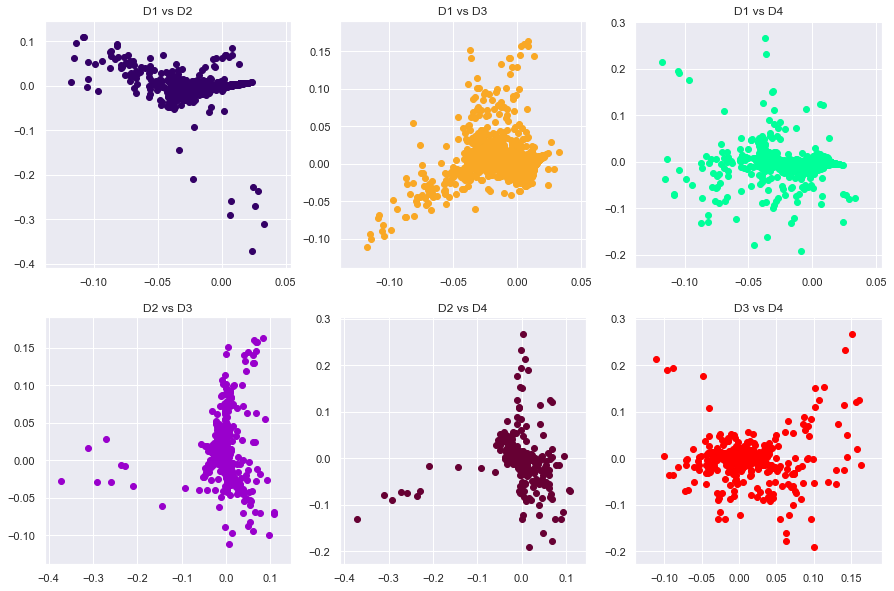

In [83]:
fig = plt.figure(figsize=(15,10))

plt.subplot(231)
plt.title("D1 vs D2")
plt.scatter(x=data_lle_final[0], y=data_lle_final[1], c = '#330066')

plt.subplot(232)
plt.title("D1 vs D3")
plt.scatter(x=data_lle_final[0], y=data_lle_final[2], c = '#F9A825')

plt.subplot(233)
plt.title("D1 vs D4")
plt.scatter(x=data_lle_final[0], y=data_lle_final[3], c = '#00FF99')

plt.subplot(234)
plt.title("D2 vs D3")
plt.scatter(x=data_lle_final[1], y=data_lle_final[2], c = '#9900CC')

plt.subplot(235)
plt.title("D2 vs D4")
plt.scatter(x=data_lle_final[1], y=data_lle_final[3], c = '#660033')

plt.subplot(236)
plt.title("D3 vs D4")
plt.scatter(x=data_lle_final[2], y=data_lle_final[3], c = 'red')

LLE is a non-linear dimensionality reduction algorithm which seeks a lower-dimensional projection of the data preserving the distances within local neighborhoods. It can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding.
LLE is sensitive to outliers and noise. Datasets have a varying density and it is not always possible to have a smooth manifold. In these cases, LLE gives a poor result.
<p>We notice the following observations from the pairplot:</p>
<ul>
     <li>As the goal of LLE is to ‘unroll’ or ‘unpack’ in distorted fashion the structure of the data, LLE will tend to have a high density in the center with extending rays.</li>
    <li>LLE projection distorts the shape of the embeddings, but it preserves the local distances between the neighbours. From the pairplot of D1 vs D2, we see that a few points lie in extreme corners of the plot and thus must be very different from the rest of set.</li>

 

<li>On the pair plot, the points lying very close to each other have a high cosine similarity whereas different words are far apart from each other.</li>
</ul>

### PART 3:  VISUALIZATION OF LLE EMBEDDINGS FOR TEST SET

In [84]:
from sklearn.manifold import LocallyLinearEmbedding

lle_model = LocallyLinearEmbedding(n_neighbors = 15)
new_values = lle_model.fit_transform(tokens)

## data-frame for the LLE embeddings of the test dataset
test_set_lle_df = pd.DataFrame(data = new_values, index = labels)

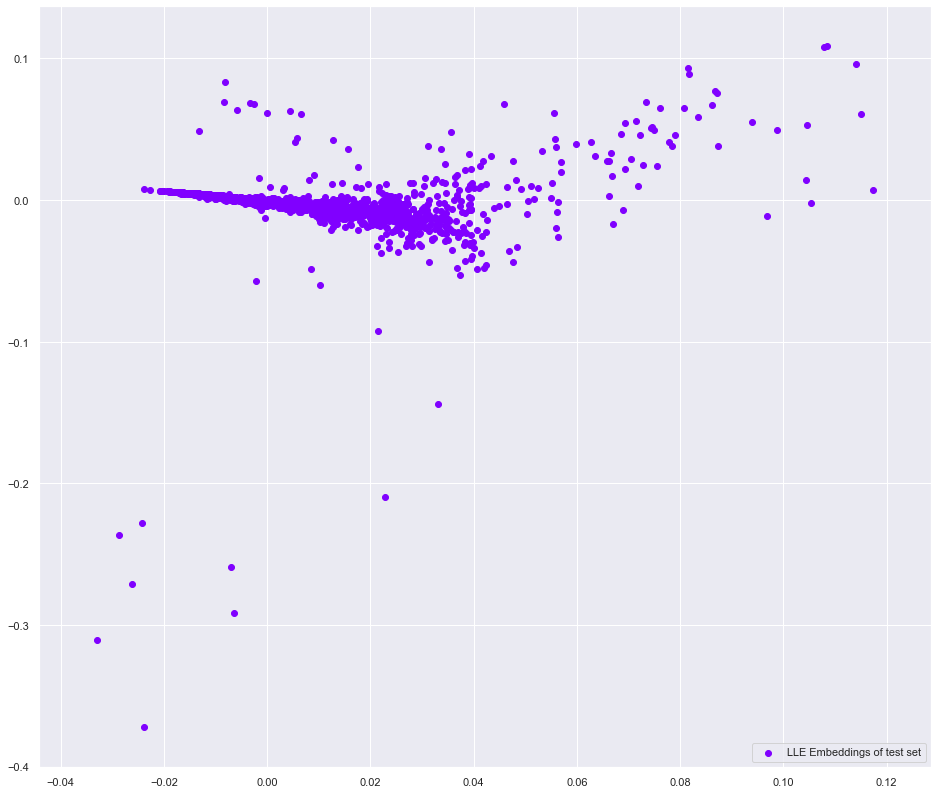

In [85]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def lle_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 14))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

lle_plot_2d('LLE Embeddings of test set', new_values, a=1)

C:\Users\DEEP\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\DEEP\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


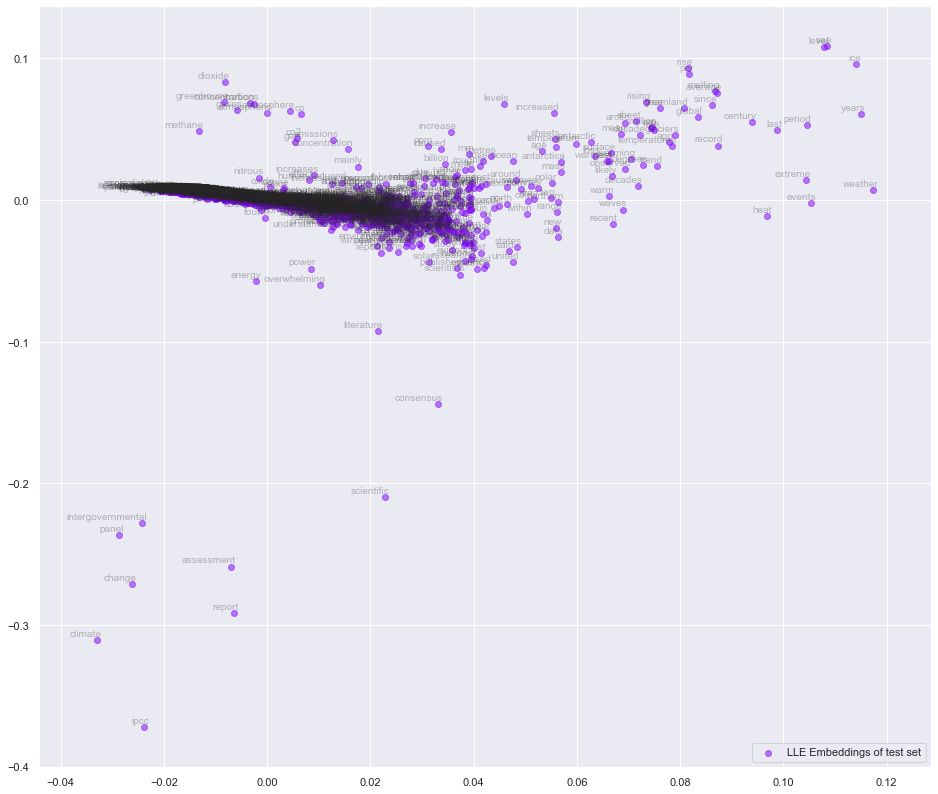

In [86]:
lle_plot_2d('LLE Embeddings of test set', new_values, labels, 0.5)

<p>The above graph shows 2D plot for the test set embedding, with and without annotations. The following key points are observed using these plots:<p>
<ul>
            <li>The plot is scattered in three linear directions from (0,0). This indicates that words which are similar tend to divide in three different directions caused by LLE embeddings</li>
            <li>It is difficult to interpret the annotations of the words in the cluster as they are very closely spaced.</li>
</ul>

In [87]:
embedding_df = test_set_lle_df

### COMPARISON OF LLE EMBEDDINGS TO WORD2VEC EMBEDDINGS

In [88]:
embedding_df.reset_index(level=0, inplace=True)

### COSINE SIMILARITY FUNCTION FOR LLE EMBEDDING CALCULATIONS

In [89]:
def cosine_calc(inp):
    score = []
    word_list = []
    for i in range(len(new_list)):
        if inp == embedding_df['index'][i]:
                for j in range(len(new_list)):
                    cosine_similarity = np.dot(new_values[i], new_values[j])/(np.linalg.norm(new_values[i])* np.linalg.norm(new_values[j]))
                    score.append(cosine_similarity)
                    word_list.append(embedding_df['index'][j])
                cosine_scores = pd.DataFrame({'word': word_list, 'cosine_score': score}, columns = ['word','cosine_score'])
                cosine_scores = cosine_scores.sort_values(by=['cosine_score'], ascending=False)
                return cosine_scores.head(10)

In [90]:
print("Most similar words to degrees")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('degrees'))
print("\nResults by LLE embeddings: " ) 
print(cosine_calc('degrees'))

Most similar words to degrees

Results by Word2vec model: 
[('fahrenheit', 0.9980664253234863), ('celsius', 0.9980367422103882), ('mm/yr', 0.9887265563011169), ('judge', 0.9878296852111816), ('warmer', 0.9871833324432373), ('occurred', 0.9868868589401245), ('end', 0.9832624197006226), ('risen', 0.9823897480964661), ('anomaly', 0.9821153283119202), ('projected', 0.9817578792572021)]

Results by LLE embeddings: 
                word  cosine_score
227          degrees      1.000000
2746            mass      0.999992
1506           parts      0.999991
27             would      0.999849
486         observed      0.999822
1360           trend      0.999806
292           little      0.999662
115        expansion      0.999554
247   pre-industrial      0.999551
1416       sea-level      0.999535


In [91]:
print("Most similar words to warming")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('warming'))
print("\nResults by LLE embeddings: " ) 
print(cosine_calc('warming'))

Most similar words to warming

Results by Word2vec model: 
[('observed', 0.9773726463317871), ('global', 0.9619247913360596), ('decades', 0.9589686989784241), ('cause', 0.9447157382965088), ('recent', 0.9444345235824585), ('trend', 0.9352955222129822), ('dominant', 0.9283832311630249), ('potentials', 0.9113823175430298), ('continuation', 0.9111177921295166), ('personally', 0.9099338054656982)]

Results by LLE embeddings: 
               word  cosine_score
1668        warming      1.000000
57             past      0.999997
297         retreat      0.999996
477         warmest      0.999996
698          tonnes      0.999895
3111           caps      0.999895
1835      indicated      0.999829
2544  anthropogenic      0.999752
2786         higher      0.999742
954      fahrenheit      0.999710


In [92]:
print("Most similar words to hemisphere")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('hemisphere'))
print("\nResults by LLE embeddings: " ) 
print(cosine_calc('hemisphere'))

Most similar words to hemisphere

Results by Word2vec model: 
[('northern', 0.9933199882507324), ('warm', 0.9903483390808105), ('data', 0.9856223464012146), ('medieval', 0.9854971766471863), ('satellite', 0.9806569814682007), ('hottest', 0.9787989854812622), ('deduce', 0.9784439206123352), ('mwp', 0.9773468375205994), ('high-end', 0.9770970344543457), ('summer', 0.9764232635498047)]

Results by LLE embeddings: 
              word  cosine_score
2945    hemisphere      1.000000
2895        likely      0.999983
3077      coverage      0.999966
87          extent      0.999837
1443    long-lived      0.999720
923            end      0.999683
2673       glacial      0.999673
1913          west      0.999660
858   human-caused      0.999573
2347         polar      0.999557


In [93]:
print("Most similar words to antarctica")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('antarctica'))
print("\nResults by LLE embeddings: " ) 
print(cosine_calc('antarctica'))

Most similar words to antarctica

Results by Word2vec model: 
[('mass', 0.9960851669311523), ('loss', 0.9955850839614868), ('land-based', 0.9942046403884888), ('caps', 0.9940021634101868), ('melt', 0.9932713508605957), ('alpine', 0.9925316572189331), ('shrinkage', 0.9919254183769226), ('extents', 0.9911638498306274), ('shelves', 0.99113929271698), ('antarctic', 0.990328311920166)]

Results by LLE embeddings: 
              word  cosine_score
1363    antarctica      1.000000
108           snow      0.999998
1009  temperatures      0.999930
1397    permafrost      0.999926
500        leading      0.999918
1953       celsius      0.999906
798           loss      0.999878
2219       surface      0.999840
1336          last      0.999803
795            due      0.999651


In [94]:
print("Most similar words to greenland")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('greenland'))
print("\nResults by LLE embeddings: " ) 
print(cosine_calc('greenland'))

Most similar words to greenland

Results by Word2vec model: 
[('sheet', 0.9972240328788757), ('sheets', 0.9941798448562622), ('melting', 0.9936009645462036), ('ice', 0.9925915598869324), ('glaciers', 0.9866825938224792), ('antarctic', 0.9859084486961365), ('arctic', 0.9756003618240356), ('caps', 0.9696984887123108), ('loss', 0.9653213620185852), ('antarctica', 0.9572653770446777)]

Results by LLE embeddings: 
               word  cosine_score
1988      greenland      1.000000
702          arctic      0.999950
256              mm      0.999947
793           sheet      0.999900
1193          since      0.999885
288          sheets      0.999805
740             ice      0.999781
2023  human-induced      0.999603
856            year      0.999558
1106        average      0.999346


<table>
  <tr>
    <th>Word</th>
    <th>Most_similar using Word2Vec (Cosine measure)</th>
    <th>Most_similar using LLE (Cosine measure)</th>
  </tr>
  <tr>
    <td>Degrees</td>
    <td>fahrenheit, celcius, mm/yr, warmer, anomaly</td>
    <td>mass, parts, trend, little, expansion</td>
   </tr>
  <tr>
    <td>Warming</td>
    <td>observed, global, cause, decades, dominant</td>
    <td>warmest, caps, fahrenheit, anthropogenic, retreat</td>
   </tr>
  <tr>
    <td>hemisphere</td>
    <td>northern, warm, data, decades, medieval</td>
    <td>polar, glacial, coverage, west, extent</td>
   </tr>
   <tr>
    <td>antarctica</td>
    <td>mass, loss, caps, land-based, alpine</td>
    <td>snow, temperature, permafrost, celsius, surface</td>
   </tr>
   <tr>
    <td>greenland</td>
    <td>sheets, melting, ice, glaciers, antarctic</td>
    <td>arctic, mm, sheets, ice, year</td>
   </tr>
</table>

<p>It can be seen that most similar words using LLE embedding are different compared to the embedding of trained Word2Vec model. The information conveyed by Word2Vec embeddings are more appropriate compared to LLE embeddings as the number of dimensions are reduced in LLE that can change the cosine similarity scores among different words. It can also be seen that the information provided by LLE embeddings are correct in many cases though not exactly related to that words.</p>

### LLE EMBEDDING VISUALIZATION FOR MOST SIMILAR WORDS

<p>Using user built functions, we have incorporated a method to represent the most similar word (found using LLE embeddings) and plot it as single colour (in a group), an approach which is similar to plotting 10 nearest neighbors (in out case most similar word found using LLE embedding)<p>
<ul>
            <li>A key of words is decided, whose most similar words are to be plotted.</li>
            <li>Based on the LLE embeddings, most similar words are calculated using the cosine_calc function.</li>
            <li>All the similar embeddings and words are clustered in a single group (in our case using colours).</li>
            <li>Based on the LLE embadding a graph is constructed to represent similar groups based on cosine metric.</li>
</ul>

In [95]:
test_set_lle_df = pd.DataFrame(new_values, index = new_list, columns = ['D1','D2'])
test_set_lle_df.head()

keys = ['greenhouse', 'deforestation', 'arctic', 'industrial', 'energy', 'temperature', 'surface', 'scientific', 'radiation']
lle_similarity_list = [list(cosine_calc(word)['word']) for word in keys]

test_set_lle_df = pd.DataFrame(new_values, index = new_list, columns = ['D1','D2'])
test_set_lle_df.head()

embedding_clusters = []
word_clusters = []


for similar_list in lle_similarity_list:
    embeddings = []
    words = []
    for word in similar_list:
        words.append(word)
        embeddings.append(list(test_set_lle_df.loc[word][:]))
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
embedding_clusters = np.array(embedding_clusters)

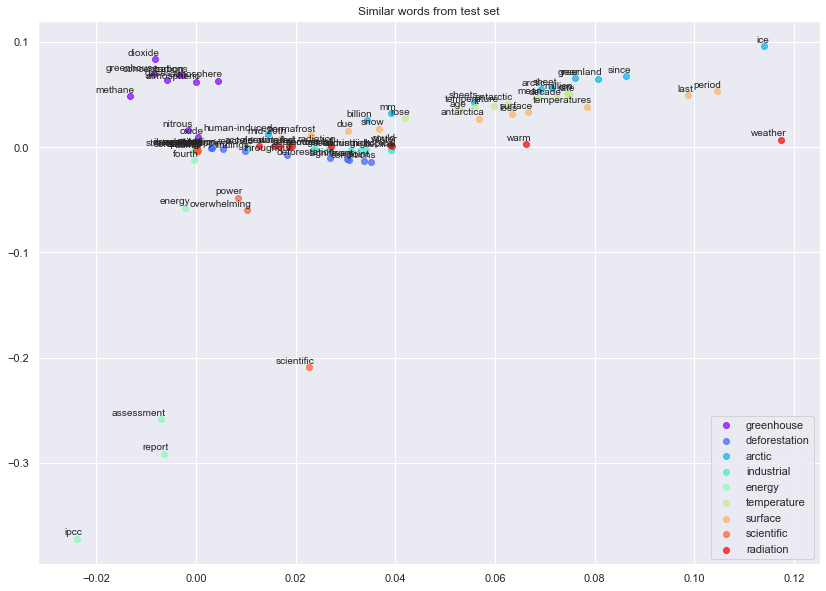

In [96]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def lle_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(14, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


lle_plot_similar_words('Similar words from test set', keys, embedding_clusters, word_clusters, 0.7,
                        'similar_words.png')

<p>There is a clear seperation between words of same type and having a strong cosine similarity score.</p>
<ul>
            <li>All the vector embeddings start from (0,0) and move away in a single direction based on the classes.</li>
            <li>Since cosine similarity score is computed using vector representation of embeddings, it can be observed that similar score based words are lying very close to each other (approximatly on a single vector) in the vector space.</li>
            <li>Compared to PCA, the embeddings share a more linear trend, the placement of points appears to be on a straight line of each set of similar words. This indicates a strong cosine score among similiar word and acts as an improvement over PCA embeddings.</li>
            <li>Words like carbon, oil, solar are located nearby to greenhouse (denoted using purple) as they have a similar cosine score.</li>
            <li>Words like fossil, anthropogenic are located nearby to energy (denoted using green) as they have a similar cosine score.</li>
            <li>Words like economic, environmental, health are located nearby to radiation (denoted using red) as they have a similar cosine score.</li>
            <li>Words like human-caused, fuel, revolution are located nearby to deforsetation (denoted using dark blue) as they have a similar cosine score.</li>
            <li>Words like human, fossil, fuels are located nearby to industrial (denoted using cyan) as they have a similar cosine score.</li>
            <li>Words like greenland, sheet, antarctic are located nearby to arctic (denoted using blue) as they have a similar cosine score.</li>
            <li>Words like range, high, states are located nearby to temperature (denoted using light green) as they have a similar cosine score.</li>
            <li>Words like degrees, rate, million are located nearby to surface (denoted using light orange) as they have a similar cosine score.</li>
            <li>It can be seen that temperature and surface are very closely placed as they have a siginifcant relationship among them based on their similarity. Moreover, their similar word's embeddings are also placed very nearby.</li>
</ul>